In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MRS_path = "/content/drive/My Drive/Lipid Peak/DB_F.mat"
MRS_C_path="/content/drive/My Drive/Lipid Peak/DB_FC.mat"
ppm_path="/content/drive/My Drive/Lipid Peak/ppm.mat"

Mounted at /content/drive


In [ ]:
!pip install talos
import talos

     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 5.4 MB 7.8 MB/s 
     |████████████████████████████████| 51 kB 633 kB/s 
     |████████████████████████████████| 9.8 MB 32.9 MB/s 
     |████████████████████████████████| 2.6 MB 39.4 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41609 sha256=683903396eaa12e65f7a6812e5f23d2f4b8c66d0513631034f1be4824dace5cb
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-py3-none-any.whl size=3603 sha256=24c7639a0e7b5dc484eac5b7b3030bada407f42add0fbfd052affcfca8bec3ed
  Stored in directory: /root/.cache/pip/wheels/1c/b4/c8/d1533d85f7fc617e3201c3f41b79fe49ae9284c8fc4a5bd4b2
Successfully built chances kerasplotlib
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully unin

In [ ]:
import numpy as np
from scipy import signal, io
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from scipy import signal
from scipy.fft import fftshift
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
import itertools
from tensorflow.keras.optimizers import Adam
from keras import optimizers
#import talos
from talos.model.normalizers import lr_normalizer
import copy
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
import math


In [ ]:
def read_DB(MRS_path,MRS_C_path, fs):
  MRS_F=io.loadmat(MRS_path)
  MRS_F=MRS_F['MRS']
  MRS_FC=io.loadmat(MRS_C_path)
  MRS_FC=MRS_FC['MRS_Clean']

  Data = []
  DataC = []
  DataMRS = []
  DataMRSC = []

  for (MRS,MRSC) in zip(MRS_F,MRS_FC):
      DataMRS.append(MRS)
      DataMRSC.append(MRSC)

  DATA=np.asarray(DataMRS)
  DATAC=np.asarray(DataMRSC)
  return DATAC, DATA


(63, 1024, 1)
(44, 1024, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1022, 128)         512       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1016, 16)          1552      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 1018, 16)          784       
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 1020, 32)          1568      
_________________________________________________________________
conv1d_transpose_5 (Conv1D

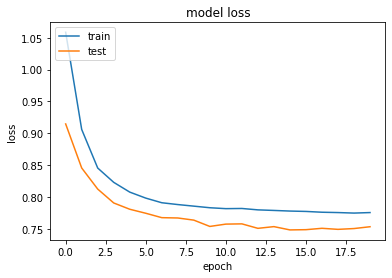

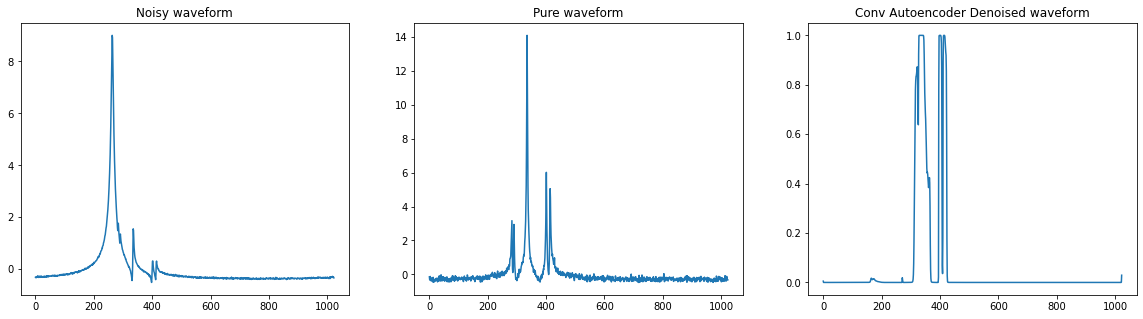

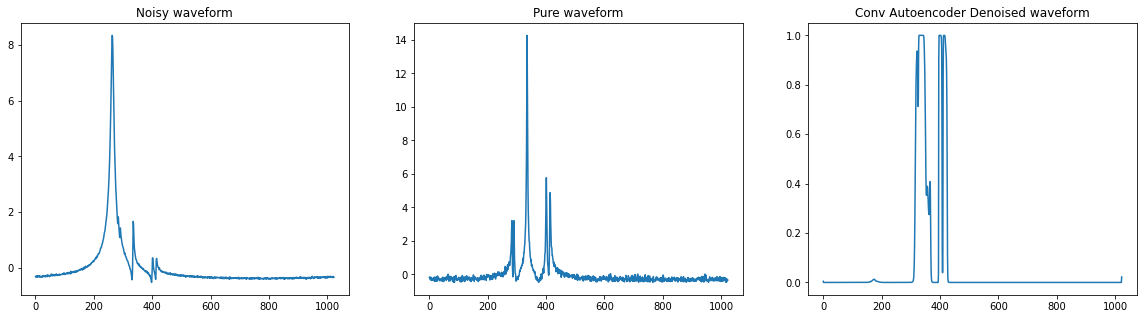

In [ ]:
# Model configuration
batch_size = 5
no_epochs = 20
train_test_split = 0.3
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0

#Load and split data
fs=2000
DATAC, DATA=read_DB(MRS_path,MRS_C_path, fs)
input_shape = (DATA.shape[1],1)
noisy_input=DATA.reshape((DATA.shape[0], DATA.shape[1], 1))
pure_input=DATAC.reshape((DATAC.shape[0], DATAC.shape[1], 1))
print(noisy_input.shape)

# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]
print(noisy_input.shape)

# Create the model
model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(32, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(128, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, activation='sigmoid', padding='same'))

model.summary()

# Compile and fit data
model.compile(optimizer='adam', loss='mse')

history = model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Generate reconstructions
num_reconstructions = 2
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)

# Plot reconstructions
for i in np.arange(0, num_reconstructions):
  # Prediction index
  prediction_index = i + percentage_training
  # Get the sample and the reconstruction
  original = DATA[prediction_index]
  pure = DATAC[prediction_index]
  reconstruction = np.array(reconstructions[i])
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3, figsize=(20, 5))
  # Plot sample and reconstruciton
  axes[0].plot(original)
  axes[0].set_title('Noisy waveform')
  axes[1].plot(pure)
  axes[1].set_title('Pure waveform')
  axes[2].plot(reconstruction)
  axes[2].set_title('Conv Autoencoder Denoised waveform')
  plt.show()


In [ ]:
def minimal(MRS_path,MRS_C_path, fs):

    validation_split = 0.2
    #Load and split data
    DATAC, DATA=read_DB(MRS_path,MRS_C_path, fs)
    input_shape = (DATA.shape[1],1)
    noisy_input=DATA.reshape((DATA.shape[0], DATA.shape[1], 1))
    pure_input=DATAC.reshape((DATAC.shape[0], DATAC.shape[1], 1))

    # Train/test split
    percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
    noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
    pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

    p = {'optimizer': [Adam],
         'lr':[0.5, 0.1, 0.01, 1e-3],
         'loss': ['mse'],
         'activation': ['elu', 'relu', 'sigmoid', 'softmax', 'tanh'],
         'Kernel_ini': ['glorot_normal', 'glorot_uniform', 'he_normal', 'he_normal'],
         'metrics': ['mse'],
         'batch_size':[5, 10, 15, 20, 30],
         'epochs':[5, 10, 20, 30, 50]}

    def autoencoder_model(noisy_input, pure_input, noisy_input_test, pure_input_test, params):

        # Create the model
        model = Sequential()
        model.add(Conv1D(128, kernel_size=3, activation=params['activation'], kernel_initializer=params['Kernel_ini'], input_shape=input_shape))
        model.add(Conv1D(64, kernel_size=3, activation=params['activation'], kernel_initializer=params['Kernel_ini']))
        model.add(Conv1D(32, kernel_size=3, activation=params['activation'], kernel_initializer=params['Kernel_ini']))
        model.add(Conv1DTranspose(32, kernel_size=3, activation=params['activation'], kernel_initializer=params['Kernel_ini']))
        model.add(Conv1DTranspose(64, kernel_size=3, activation=params['activation'], kernel_initializer=params['Kernel_ini']))
        model.add(Conv1DTranspose(128, kernel_size=3, activation=params['activation'], kernel_initializer=params['Kernel_ini']))
        model.add(Conv1D(1, kernel_size=3, activation='sigmoid', padding='same'))

        model.summary()
        model.compile(loss=params['loss'], optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])), metrics=params['metrics'])

        history = model.fit(noisy_input, pure_input, batch_size=params['batch_size'], epochs=params['epochs'], validation_data=(noisy_input_test, pure_input_test))

        return history, model

    scan_object = talos.Scan(x=noisy_input, y=pure_input, params=p, model=autoencoder_model, experiment_name='autoencoder', x_val=noisy_input_test, y_val=pure_input_test, val_split=validation_split,  fraction_limit=0.1)

    return scan_object

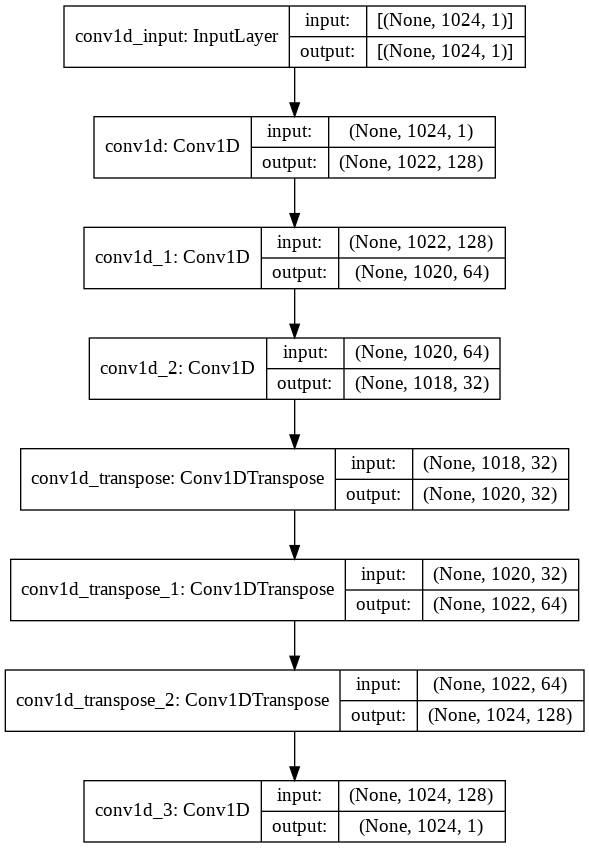

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
scan_object= minimal(MRS_path,MRS_C_path, fs)
    # accessing the results data frame
scan_object.data.head()

    # accessing epoch entropy values for each round
scan_object.learning_entropy

    # access the summary details
scan_object.details

  0%|          | 0/200 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1022, 128)         512       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1024, 1)          

  0%|          | 1/200 [00:06<21:03,  6.35s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  1%|          | 2/200 [00:32<58:32, 17.74s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  2%|▏         | 3/200 [00:41<45:24, 13.83s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  2%|▏         | 4/200 [01:23<1:22:24, 25.23s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  2%|▎         | 5/200 [01:41<1:12:49, 22.41s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  3%|▎         | 6/200 [01:47<54:48, 16.95s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  4%|▎         | 7/200 [02:09<59:32, 18.51s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  4%|▍         | 8/200 [02:27<58:33, 18.30s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  4%|▍         | 9/200 [02:47<59:47, 18.78s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  5%|▌         | 10/200 [02:53<47:20, 14.95s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  6%|▌         | 11/200 [03:35<1:13:24, 23.30s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  6%|▌         | 12/200 [03:46<1:00:51, 19.42s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  6%|▋         | 13/200 [04:28<1:21:55, 26.29s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  7%|▋         | 14/200 [04:49<1:17:06, 24.87s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  8%|▊         | 15/200 [05:32<1:32:41, 30.06s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  8%|▊         | 16/200 [06:21<1:50:20, 35.98s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  8%|▊         | 17/200 [07:03<1:55:20, 37.82s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

  9%|▉         | 18/200 [07:10<1:25:56, 28.33s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 10%|▉         | 19/200 [08:33<2:15:04, 44.77s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 10%|█         | 20/200 [08:44<1:44:19, 34.78s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 10%|█         | 21/200 [09:26<1:50:26, 37.02s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 11%|█         | 22/200 [09:33<1:22:32, 27.82s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 12%|█▏        | 23/200 [09:39<1:03:06, 21.39s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 12%|█▏        | 24/200 [09:46<49:31, 16.89s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 12%|█▎        | 25/200 [10:07<53:30, 18.34s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 13%|█▎        | 26/200 [10:18<46:09, 15.91s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 14%|█▎        | 27/200 [10:23<37:09, 12.89s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 14%|█▍        | 28/200 [11:06<1:02:10, 21.69s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 14%|█▍        | 29/200 [11:12<48:33, 17.04s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 15%|█▌        | 30/200 [11:33<51:30, 18.18s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 16%|█▌        | 31/200 [11:39<41:14, 14.64s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 16%|█▌        | 32/200 [11:59<45:07, 16.11s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 16%|█▋        | 33/200 [13:22<1:40:53, 36.25s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 17%|█▋        | 34/200 [13:33<1:19:49, 28.86s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 18%|█▊        | 35/200 [13:40<1:00:55, 22.15s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 18%|█▊        | 36/200 [13:52<51:53, 18.98s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 18%|█▊        | 37/200 [14:34<1:10:38, 26.00s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 19%|█▉        | 38/200 [14:56<1:06:50, 24.76s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 20%|█▉        | 39/200 [15:02<51:41, 19.26s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 20%|██        | 40/200 [15:44<1:09:46, 26.17s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 20%|██        | 41/200 [16:16<1:13:49, 27.86s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 21%|██        | 42/200 [16:23<56:25, 21.43s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 22%|██▏       | 43/200 [16:34<48:20, 18.47s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 22%|██▏       | 44/200 [16:56<50:36, 19.46s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 22%|██▎       | 45/200 [17:06<43:14, 16.74s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 23%|██▎       | 46/200 [17:13<35:01, 13.65s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 24%|██▎       | 47/200 [17:55<56:40, 22.22s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 24%|██▍       | 48/200 [18:22<59:41, 23.56s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 24%|██▍       | 49/200 [18:44<58:00, 23.05s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 25%|██▌       | 50/200 [18:50<45:07, 18.05s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 26%|██▌       | 51/200 [19:32<1:03:00, 25.38s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 26%|██▌       | 52/200 [19:39<48:16, 19.57s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 26%|██▋       | 53/200 [19:50<42:07, 17.19s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 27%|██▋       | 54/200 [20:13<46:16, 19.02s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 28%|██▊       | 55/200 [20:35<48:05, 19.90s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 28%|██▊       | 56/200 [20:49<43:15, 18.02s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 28%|██▊       | 57/200 [20:56<34:47, 14.60s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 29%|██▉       | 58/200 [21:07<32:32, 13.75s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 30%|██▉       | 59/200 [21:29<38:08, 16.23s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 30%|███       | 60/200 [22:53<1:24:53, 36.38s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 30%|███       | 61/200 [23:04<1:06:58, 28.91s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 31%|███       | 62/200 [23:11<50:56, 22.15s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 32%|███▏      | 63/200 [23:17<39:24, 17.26s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 32%|███▏      | 64/200 [24:40<1:23:58, 37.05s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 32%|███▎      | 65/200 [26:03<1:54:31, 50.90s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 33%|███▎      | 66/200 [26:48<1:49:58, 49.24s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 34%|███▎      | 67/200 [27:31<1:44:28, 47.14s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 34%|███▍      | 68/200 [27:37<1:16:47, 34.90s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 34%|███▍      | 69/200 [28:23<1:23:17, 38.15s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 35%|███▌      | 70/200 [29:46<1:51:56, 51.67s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 36%|███▌      | 71/200 [29:52<1:21:49, 38.06s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 36%|███▌      | 72/200 [30:02<1:02:52, 29.47s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 36%|███▋      | 73/200 [30:44<1:10:28, 33.29s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 37%|███▋      | 74/200 [30:50<52:54, 25.19s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 38%|███▊      | 75/200 [31:02<43:53, 21.07s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 38%|███▊      | 76/200 [31:44<56:35, 27.38s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 38%|███▊      | 77/200 [31:54<45:52, 22.38s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 39%|███▉      | 78/200 [32:37<57:34, 28.32s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 40%|███▉      | 79/200 [32:54<50:15, 24.92s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 40%|████      | 80/200 [33:00<38:52, 19.44s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 40%|████      | 81/200 [33:06<30:42, 15.48s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 41%|████      | 82/200 [33:17<27:28, 13.97s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 42%|████▏     | 83/200 [33:23<22:44, 11.66s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 42%|████▏     | 84/200 [33:34<21:47, 11.27s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 42%|████▎     | 85/200 [33:55<27:34, 14.38s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 43%|████▎     | 86/200 [34:01<22:41, 11.94s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 44%|████▎     | 87/200 [34:07<19:08, 10.16s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 44%|████▍     | 88/200 [34:29<25:08, 13.47s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 44%|████▍     | 89/200 [34:54<31:37, 17.10s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 45%|████▌     | 90/200 [35:04<27:04, 14.77s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 46%|████▌     | 91/200 [35:46<41:43, 22.97s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 46%|████▌     | 92/200 [36:07<40:35, 22.55s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 46%|████▋     | 93/200 [36:19<34:13, 19.19s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 47%|████▋     | 94/200 [36:30<29:44, 16.83s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 48%|████▊     | 95/200 [37:53<1:04:12, 36.69s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 48%|████▊     | 96/200 [38:35<1:06:23, 38.30s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 48%|████▊     | 97/200 [38:40<48:45, 28.40s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 49%|████▉     | 98/200 [40:03<1:16:08, 44.79s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 50%|████▉     | 99/200 [40:23<1:02:48, 37.31s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 50%|█████     | 100/200 [41:05<1:04:34, 38.74s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 50%|█████     | 101/200 [42:28<1:25:50, 52.03s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 51%|█████     | 102/200 [42:56<1:12:59, 44.69s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 52%|█████▏    | 103/200 [43:23<1:03:50, 39.49s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 52%|█████▏    | 104/200 [43:29<47:12, 29.51s/it]  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 52%|█████▎    | 105/200 [43:51<42:57, 27.13s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 53%|█████▎    | 106/200 [44:17<41:52, 26.73s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 54%|█████▎    | 107/200 [44:23<31:52, 20.57s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 54%|█████▍    | 108/200 [44:29<24:41, 16.10s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 55%|█████▍    | 109/200 [44:47<25:24, 16.75s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 55%|█████▌    | 110/200 [44:58<22:41, 15.13s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 56%|█████▌    | 111/200 [45:08<20:05, 13.54s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 56%|█████▌    | 112/200 [45:14<16:38, 11.35s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 56%|█████▋    | 113/200 [45:24<15:49, 10.91s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 57%|█████▋    | 114/200 [45:36<15:49, 11.04s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 57%|█████▊    | 115/200 [45:42<13:35,  9.59s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 58%|█████▊    | 116/200 [46:01<17:37, 12.58s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 58%|█████▊    | 117/200 [46:07<14:20, 10.37s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 59%|█████▉    | 118/200 [46:28<18:46, 13.73s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 60%|█████▉    | 119/200 [47:51<46:37, 34.53s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 60%|██████    | 120/200 [48:13<40:51, 30.64s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 60%|██████    | 121/200 [48:43<40:14, 30.57s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 61%|██████    | 122/200 [48:49<30:14, 23.26s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 62%|██████▏   | 123/200 [48:55<22:53, 17.84s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 62%|██████▏   | 124/200 [49:06<20:07, 15.89s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 62%|██████▎   | 125/200 [49:48<29:40, 23.74s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 63%|██████▎   | 126/200 [50:10<28:28, 23.09s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 64%|██████▎   | 127/200 [51:33<49:58, 41.07s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 64%|██████▍   | 128/200 [51:59<43:51, 36.55s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 64%|██████▍   | 129/200 [52:20<37:55, 32.05s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 65%|██████▌   | 130/200 [53:01<40:27, 34.67s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 66%|██████▌   | 131/200 [53:43<42:25, 36.88s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 66%|██████▌   | 132/200 [53:54<33:06, 29.22s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 66%|██████▋   | 133/200 [54:36<36:56, 33.08s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 67%|██████▋   | 134/200 [54:48<29:12, 26.55s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 68%|██████▊   | 135/200 [56:11<47:06, 43.49s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 68%|██████▊   | 136/200 [56:52<45:34, 42.73s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 68%|██████▊   | 137/200 [57:11<37:36, 35.81s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 69%|██████▉   | 138/200 [57:18<27:49, 26.93s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 70%|██████▉   | 139/200 [57:29<22:37, 22.25s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 70%|███████   | 140/200 [57:54<23:08, 23.13s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 70%|███████   | 141/200 [58:03<18:36, 18.92s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 71%|███████   | 142/200 [58:25<19:03, 19.72s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3

 72%|███████▏  | 143/200 [59:48<36:47, 38.72s/it]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 128)         512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1020, 64)          24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 32)          6176      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1020, 32)          3104      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 1022, 64)          6208      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 1024, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 1)           3